### Testing access to the NHL API

In [1]:
import pandas as pd
from nhlpy.api.query.builder import QueryBuilder, QueryContext
from nhlpy.nhl_client import NHLClient
from nhlpy.api.query.filters.franchise import FranchiseQuery
from nhlpy.api.query.filters.shoot_catch import ShootCatchesQuery
from nhlpy.api.query.filters.draft import DraftQuery
from nhlpy.api.query.filters.season import SeasonQuery
from nhlpy.api.query.filters.game_type import GameTypeQuery
from nhlpy.api.query.filters.position import PositionQuery, PositionTypes
from nhlpy.api.query.filters.status import StatusQuery
from nhlpy.api.query.filters.opponent import OpponentQuery
from nhlpy.api.query.filters.home_road import HomeRoadQuery
from nhlpy.api.query.filters.experience import ExperienceQuery
from nhlpy.api.query.filters.decision import DecisionQuery

In [2]:
client = NHLClient(verbose=True)

In [3]:
print(client)

## Team info prep

Using teams_info method with date parameter fetches inforamtion about the team for the given date.

In [4]:
team_info = client.teams.teams_info(date="2024-10-31")

INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/standings/2024-10-31 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/standings/2024-10-31
INFO:httpx:HTTP Request: GET https://api.nhle.com/stats/rest/en/franchise "HTTP/1.1 200 OK"
INFO:root:API URL: https://api.nhle.com/stats/rest/en/franchise


In [5]:
df_team_info = pd.DataFrame(team_info)

In [6]:
df_team_info.head()

,conference,division,name,common_name,abbr,logo,franchise_id
0,"{'abbr': 'W', 'name': 'Western'}","{'abbr': 'C', 'name': 'Central'}",Winnipeg Jets,Jets,WPG,https://assets.nhle.com/logos/nhl/svg/WPG_ligh...,35
1,"{'abbr': 'E', 'name': 'Eastern'}","{'abbr': 'M', 'name': 'Metropolitan'}",New Jersey Devils,Devils,NJD,https://assets.nhle.com/logos/nhl/svg/NJD_ligh...,23
2,"{'abbr': 'W', 'name': 'Western'}","{'abbr': 'P', 'name': 'Pacific'}",Vegas Golden Knights,Golden Knights,VGK,https://assets.nhle.com/logos/nhl/svg/VGK_ligh...,38
3,"{'abbr': 'E', 'name': 'Eastern'}","{'abbr': 'A', 'name': 'Atlantic'}",Florida Panthers,Panthers,FLA,https://assets.nhle.com/logos/nhl/svg/FLA_ligh...,33
4,"{'abbr': 'E', 'name': 'Eastern'}","{'abbr': 'M', 'name': 'Metropolitan'}",Washington Capitals,Capitals,WSH,https://assets.nhle.com/logos/nhl/svg/WSH_seco...,24


Data in some fields is stored as a dictionary with abbreviated and full names, namely for Conference and Division.

We can access a full name value under a given key with the get method:

In [7]:
df_team_info["conference"].apply(lambda x: x.get("name") if isinstance(x, dict) else x).unique()

array(['Western', 'Eastern'], dtype=object)

Now wrapping it under a function that accepts a column name and a dictionary key as arguments.

In [8]:
def get_default_value(column, get_value):
    return column.apply(lambda x: x.get(get_value) if isinstance(x, dict) else x)

Create a loop to go through columns we want to change.

In [9]:
columns_to_change = ["conference", "division"]

for column in columns_to_change:
    df_team_info[column] = get_default_value(df_team_info[column], "name")

In [10]:
df_team_info.head()

,conference,division,name,common_name,abbr,logo,franchise_id
0,Western,Central,Winnipeg Jets,Jets,WPG,https://assets.nhle.com/logos/nhl/svg/WPG_ligh...,35
1,Eastern,Metropolitan,New Jersey Devils,Devils,NJD,https://assets.nhle.com/logos/nhl/svg/NJD_ligh...,23
2,Western,Pacific,Vegas Golden Knights,Golden Knights,VGK,https://assets.nhle.com/logos/nhl/svg/VGK_ligh...,38
3,Eastern,Atlantic,Florida Panthers,Panthers,FLA,https://assets.nhle.com/logos/nhl/svg/FLA_ligh...,33
4,Eastern,Metropolitan,Washington Capitals,Capitals,WSH,https://assets.nhle.com/logos/nhl/svg/WSH_seco...,24


Saving teams abbreviations as a series for further iterations. 

In [11]:
s_teams = df_team_info["abbr"]

In [12]:
s_teams.info()

<class 'pandas.core.series.Series'>
RangeIndex: 32 entries, 0 to 31
Series name: abbr
Non-Null Count  Dtype 
--------------  ----- 
32 non-null     object
dtypes: object(1)
memory usage: 388.0+ bytes


## Roster Data analysis

In roster table, we want to get players attributes for further filtering

In [13]:
# Select a season and a team to perform a query
season_id = 20242025
team_abbr = "COL"

In [14]:
roster_data = client.teams.roster(team_abbr=team_abbr, season=season_id)

INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/roster/COL/20242025 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/roster/COL/20242025


Let's inspect the object we received from the query.

In [15]:
roster_data

{'forwards': [{'id': 8479525,
   'headshot': 'https://assets.nhle.com/mugs/nhl/20242025/COL/8479525.png',
   'firstName': {'default': 'Ross'},
   'lastName': {'default': 'Colton'},
   'sweaterNumber': 20,
   'positionCode': 'C',
   'shootsCatches': 'L',
   'heightInInches': 72,
   'weightInPounds': 194,
   'heightInCentimeters': 183,
   'weightInKilograms': 88,
   'birthDate': '1996-09-11',
   'birthCity': {'default': 'Robbinsville'},
   'birthCountry': 'USA',
   'birthStateProvince': {'default': 'NJ'}},
  {'id': 8477494,
   'headshot': 'https://assets.nhle.com/mugs/nhl/20242025/COL/8477494.png',
   'firstName': {'default': 'Jonathan'},
   'lastName': {'default': 'Drouin'},
   'sweaterNumber': 27,
   'positionCode': 'L',
   'shootsCatches': 'L',
   'heightInInches': 71,
   'weightInPounds': 198,
   'heightInCentimeters': 180,
   'weightInKilograms': 90,
   'birthDate': '1995-03-28',
   'birthCity': {'default': 'Ste-Agathe'},
   'birthCountry': 'CAN',
   'birthStateProvince': {'default'

The returned dictionary contains positions as keys and list of dictionaries with individual players' info as values. Let's inspect the goalies record. 

In [16]:
roster_data["goalies"]

[{'id': 8478406,
  'headshot': 'https://assets.nhle.com/mugs/nhl/20242025/COL/8478406.png',
  'firstName': {'default': 'Mackenzie'},
  'lastName': {'default': 'Blackwood'},
  'sweaterNumber': 39,
  'positionCode': 'G',
  'shootsCatches': 'L',
  'heightInInches': 76,
  'weightInPounds': 225,
  'heightInCentimeters': 193,
  'weightInKilograms': 102,
  'birthDate': '1996-12-09',
  'birthCity': {'default': 'Thunder Bay'},
  'birthCountry': 'CAN',
  'birthStateProvince': {'default': 'ON'}},
 {'id': 8475809,
  'headshot': 'https://assets.nhle.com/mugs/nhl/20242025/COL/8475809.png',
  'firstName': {'default': 'Scott'},
  'lastName': {'default': 'Wedgewood'},
  'sweaterNumber': 41,
  'positionCode': 'G',
  'shootsCatches': 'L',
  'heightInInches': 74,
  'weightInPounds': 201,
  'heightInCentimeters': 188,
  'weightInKilograms': 91,
  'birthDate': '1992-08-14',
  'birthCity': {'default': 'Brampton'},
  'birthCountry': 'CAN',
  'birthStateProvince': {'default': 'ON'}}]

We can combine all three values for defensemen, forwards and goales in a list and convert that into a dataframe for cleaning and analysis.

In [17]:
roster_data_combined = roster_data["forwards"] + roster_data["defensemen"] + roster_data ["goalies"]

In [18]:
df_team_roster = pd.DataFrame(roster_data_combined)

In [19]:
df_team_roster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   26 non-null     int64 
 1   headshot             26 non-null     object
 2   firstName            26 non-null     object
 3   lastName             26 non-null     object
 4   sweaterNumber        26 non-null     int64 
 5   positionCode         26 non-null     object
 6   shootsCatches        26 non-null     object
 7   heightInInches       26 non-null     int64 
 8   weightInPounds       26 non-null     int64 
 9   heightInCentimeters  26 non-null     int64 
 10  weightInKilograms    26 non-null     int64 
 11  birthDate            26 non-null     object
 12  birthCity            26 non-null     object
 13  birthCountry         26 non-null     object
 14  birthStateProvince   19 non-null     object
dtypes: int64(6), object(9)
memory usage: 3.2+ KB


In [20]:
df_team_roster.head()

,id,headshot,firstName,lastName,sweaterNumber,positionCode,shootsCatches,heightInInches,weightInPounds,heightInCentimeters,weightInKilograms,birthDate,birthCity,birthCountry,birthStateProvince
0,8479525,https://assets.nhle.com/mugs/nhl/20242025/COL/...,{'default': 'Ross'},{'default': 'Colton'},20,C,L,72,194,183,88,1996-09-11,{'default': 'Robbinsville'},USA,{'default': 'NJ'}
1,8477494,https://assets.nhle.com/mugs/nhl/20242025/COL/...,{'default': 'Jonathan'},{'default': 'Drouin'},27,L,L,71,198,180,90,1995-03-28,{'default': 'Ste-Agathe'},CAN,{'default': 'QC'}
2,8479746,https://assets.nhle.com/mugs/nhl/20242025/COL/...,{'default': 'Tye'},{'default': 'Felhaber'},48,L,L,71,185,180,84,1998-08-05,{'default': 'Pembroke'},CAN,{'default': 'ON'}
3,8483930,https://assets.nhle.com/mugs/nhl/20242025/COL/...,{'default': 'Ivan'},{'default': 'Ivan'},82,C,L,72,190,183,86,2002-08-20,{'default': 'Ostrava'},CZE,NaN
4,8480448,https://assets.nhle.com/mugs/nhl/20242025/COL/...,{'default': 'Parker'},{'default': 'Kelly'},17,C,L,73,185,185,84,1999-05-14,{'default': 'Camrose'},CAN,{'default': 'AB'}


Data in some of the fields is represented as dictionaries with information like First and Last Names and Birth City can be presented in multiple languages. Let's inspect them to understand how we can transform the data to make analysis easy.   

In [21]:
df_team_roster.loc[ : ,["firstName", "lastName", "birthCity", "birthStateProvince", "birthCountry"]]

,firstName,lastName,birthCity,birthStateProvince,birthCountry
0,{'default': 'Ross'},{'default': 'Colton'},{'default': 'Robbinsville'},{'default': 'NJ'},USA
1,{'default': 'Jonathan'},{'default': 'Drouin'},{'default': 'Ste-Agathe'},{'default': 'QC'},CAN
2,{'default': 'Tye'},{'default': 'Felhaber'},{'default': 'Pembroke'},{'default': 'ON'},CAN
3,{'default': 'Ivan'},{'default': 'Ivan'},{'default': 'Ostrava'},NaN,CZE
4,{'default': 'Parker'},{'default': 'Kelly'},{'default': 'Camrose'},{'default': 'AB'},CAN
5,{'default': 'Joel'},{'default': 'Kiviranta'},"{'default': 'Vantaa', 'sv': 'Vanda'}",NaN,FIN
6,{'default': 'Artturi'},{'default': 'Lehkonen'},"{'default': 'Piikkio', 'cs': 'Piikkiö', 'fi': ...",NaN,FIN
7,{'default': 'Nathan'},{'default': 'MacKinnon'},{'default': 'Halifax'},{'default': 'NS'},CAN
8,{'default': 'Casey'},{'default': 'Mittelstadt'},{'default': 'Eden Prairie'},{'default': 'MN'},USA
9,"{'default': 'Valeri', 'cs': 'Valerij', 'sk': '...","{'default': 'Nichushkin', 'cs': 'Ničuškin', 'f...","{'default': 'Chelyabinsk', 'cs': 'Čeljabinsk',...",NaN,RUS


We can reuse the function we created earlier to extract values under "default" key, which is English spellings.

In [22]:
# Test the function on the Last Name column
get_default_value(df_team_roster["lastName"], "default").tail(10)

16       Girard
17    Kylington
18       Ludvig
19        Makar
20     Malinski
21       Manson
22    Middleton
23        Toews
24    Blackwood
25    Wedgewood
Name: lastName, dtype: object

Now in the dataframe, we apply the function to the fields we want to be cleaned.

In [23]:
columns_to_change = ["firstName", "lastName", "birthCity", "birthStateProvince"]

for column in columns_to_change:
    df_team_roster[column] = get_default_value(df_team_roster[column], "default")

In [24]:
df_team_roster.loc[df_team_roster["lastName"] == "Georgiev"].T

""
id
headshot
firstName
lastName
sweaterNumber
positionCode
shootsCatches
heightInInches
weightInPounds
heightInCentimeters


For the purpose of our project we don't need certain fields such as "birthCity", "birthStateProvince", "weightInPounds" etc.

In [25]:
df_team_roster.drop(
    columns=["heightInInches", "weightInPounds", "birthCity", "birthStateProvince"],
    axis=1,
    inplace=True
)

In [26]:
df_team_roster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   26 non-null     int64 
 1   headshot             26 non-null     object
 2   firstName            26 non-null     object
 3   lastName             26 non-null     object
 4   sweaterNumber        26 non-null     int64 
 5   positionCode         26 non-null     object
 6   shootsCatches        26 non-null     object
 7   heightInCentimeters  26 non-null     int64 
 8   weightInKilograms    26 non-null     int64 
 9   birthDate            26 non-null     object
 10  birthCountry         26 non-null     object
dtypes: int64(4), object(7)
memory usage: 2.4+ KB


To be able to repeatedly clean data for all franchises, we create a function that will be reused in a loop.

In [27]:
def get_team_roster(team_abbr, season_id):
    
    # Load data
    data = client.teams.roster(team_abbr=team_abbr, season=season_id)
    data_combined = data["forwards"] + data["defensemen"] + data ["goalies"]
    df = pd.DataFrame(data_combined)

    if df.shape[1] > 0:
        # Clean columns
        columns_to_change = ["firstName", "lastName", "birthCity", "birthStateProvince"]
        for column in columns_to_change:
            df[column] = get_default_value(df[column], "default")

        # Drop columns
        df.drop(
            columns=["heightInInches", "weightInPounds", "birthCity", "birthStateProvince"],
            axis=1,
            inplace=True
        )

    return df

In [28]:
get_team_roster("DAL", "20242025").head()

INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/roster/DAL/20242025 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/roster/DAL/20242025


,id,headshot,firstName,lastName,sweaterNumber,positionCode,shootsCatches,heightInCentimeters,weightInKilograms,birthDate,birthCountry
0,8473994,https://assets.nhle.com/mugs/nhl/20242025/DAL/...,Jamie,Benn,14,L,L,191,93,1989-07-18,CAN
1,8476278,https://assets.nhle.com/mugs/nhl/20242025/DAL/...,Colin,Blackwell,15,C,R,173,86,1993-03-28,USA
2,8482145,https://assets.nhle.com/mugs/nhl/20242025/DAL/...,Mavrik,Bourque,22,C,R,180,82,2002-01-08,CAN
3,8480840,https://assets.nhle.com/mugs/nhl/20242025/DAL/...,Oskar,Bäck,10,C,L,193,92,2000-03-12,SWE
4,8474149,https://assets.nhle.com/mugs/nhl/20242025/DAL/...,Evgenii,Dadonov,63,R,L,180,85,1989-03-12,RUS


Checking what value is assigned to the season_id variable which we will use in the get_team_roster functions

In [29]:
season_id

20242025

In [30]:
list_of_roster_dfs = [] # Creating a list to store team rosters dataframes

for index, team in s_teams.items():
    df = get_team_roster(team, season_id)
    list_of_roster_dfs.append(df)

INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/roster/WPG/20242025 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/roster/WPG/20242025
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/roster/NJD/20242025 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/roster/NJD/20242025
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/roster/VGK/20242025 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/roster/VGK/20242025
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/roster/FLA/20242025 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/roster/FLA/20242025
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/roster/WSH/20242025 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/roster/WSH/20242025
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/roster/DAL/20242025 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/roster/DAL/20242025
INFO:httpx:HTTP Request: GET

In [31]:
list_of_roster_dfs

[         id                                           headshot  firstName  \
 0   8478891  https://assets.nhle.com/mugs/nhl/20242025/WPG/...      Mason   
 1   8480289  https://assets.nhle.com/mugs/nhl/20242025/WPG/...     Morgan   
 2   8482787  https://assets.nhle.com/mugs/nhl/20242025/WPG/...     Nikita   
 3   8478398  https://assets.nhle.com/mugs/nhl/20242025/WPG/...       Kyle   
 4   8477940  https://assets.nhle.com/mugs/nhl/20242025/WPG/...    Nikolaj   
 5   8481019  https://assets.nhle.com/mugs/nhl/20242025/WPG/...      David   
 6   8480113  https://assets.nhle.com/mugs/nhl/20242025/WPG/...       Alex   
 7   8480845  https://assets.nhle.com/mugs/nhl/20242025/WPG/...     Rasmus   
 8   8476392  https://assets.nhle.com/mugs/nhl/20242025/WPG/...       Adam   
 9   8476480  https://assets.nhle.com/mugs/nhl/20242025/WPG/...  Vladislav   
 10  8475799  https://assets.nhle.com/mugs/nhl/20242025/WPG/...       Nino   
 11  8482149  https://assets.nhle.com/mugs/nhl/20242025/WPG/... 

Using concat method we combine the dataframes in the list into a single dataframe.

In [32]:
df_team_roster_combined = pd.concat(list_of_roster_dfs)

In [33]:
df_team_roster_combined.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 775 entries, 0 to 25
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   775 non-null    int64 
 1   headshot             775 non-null    object
 2   firstName            775 non-null    object
 3   lastName             775 non-null    object
 4   sweaterNumber        775 non-null    int64 
 5   positionCode         775 non-null    object
 6   shootsCatches        775 non-null    object
 7   heightInCentimeters  775 non-null    int64 
 8   weightInKilograms    775 non-null    int64 
 9   birthDate            775 non-null    object
 10  birthCountry         775 non-null    object
dtypes: int64(4), object(7)
memory usage: 72.7+ KB


To test the combined dataframe, let's run a few queries.
Who is the tallest skater in the league? 

In [34]:
df_team_roster_combined.loc[df_team_roster_combined["heightInCentimeters"] == df_team_roster_combined["heightInCentimeters"].max()]

,id,headshot,firstName,lastName,sweaterNumber,positionCode,shootsCatches,heightInCentimeters,weightInKilograms,birthDate,birthCountry
20,8474574,https://assets.nhle.com/mugs/nhl/20242025/VAN/...,Tyler,Myers,57,D,R,203,104,1990-02-01,USA
16,8481806,https://assets.nhle.com/mugs/nhl/20242025/CHI/...,Louis,Crevier,46,D,R,203,103,2001-05-04,CAN


Who is the oldest Canadian goalie?

In [35]:
df_team_roster_combined.loc[
    (df_team_roster_combined['birthDate'] == df_team_roster_combined['birthDate'].min()) &
    (df_team_roster_combined['birthCountry'].str.upper() == 'CAN') &
    (df_team_roster_combined['positionCode'].str.upper() == 'G')
    ]

,id,headshot,firstName,lastName,sweaterNumber,positionCode,shootsCatches,heightInCentimeters,weightInKilograms,birthDate,birthCountry
23,8470594,https://assets.nhle.com/mugs/nhl/20242025/MIN/...,Marc-Andre,Fleury,29,G,L,188,84,1984-11-28,CAN


In [36]:
df_team_roster_combined.loc[df_team_roster_combined["id"] == 8479639].T

,14
id,8479639
headshot,https://assets.nhle.com/mugs/nhl/20242025/WPG/...
firstName,Dylan
lastName,Coghlan
sweaterNumber,52
positionCode,D
shootsCatches,R
heightInCentimeters,188
weightInKilograms,94
birthDate,1998-02-19


As goalies stats track different event compared to skaters, we pull stats for them separately.

In [37]:
df_team_roster_combined['positionCode'].unique()

array(['C', 'R', 'L', 'D', 'G'], dtype=object)

Saving skaters into a series.

In [38]:
s_skater_ids = df_team_roster_combined.loc[df_team_roster_combined['positionCode'] != "G"]['id']

In [39]:
s_skater_ids.info()

s_skater_ids.head()

<class 'pandas.core.series.Series'>
Index: 701 entries, 0 to 22
Series name: id
Non-Null Count  Dtype
--------------  -----
701 non-null    int64
dtypes: int64(1)
memory usage: 11.0 KB


0    8478891
1    8480289
2    8482787
3    8478398
4    8477940
Name: id, dtype: int64

Saving goalies ids into a series.

In [40]:
s_goalie_ids = df_team_roster_combined.loc[df_team_roster_combined['positionCode'] == "G"]['id']

In [41]:
s_goalie_ids.info()

s_goalie_ids.head()

<class 'pandas.core.series.Series'>
Index: 74 entries, 23 to 25
Series name: id
Non-Null Count  Dtype
--------------  -----
74 non-null     int64
dtypes: int64(1)
memory usage: 1.2 KB


23    8477480
24    8476945
22    8474596
23    8474593
21    8478499
Name: id, dtype: int64

## Game logs data prep

Game logs method requires player id, season id and game type arguments.
We can reuse the season id we declared earlier, while declaring the player id (Nathan MacKinnon) and game type (Regular Season) below.

In [42]:
player_id = 8477492
game_type = 2

In [43]:
game_logs_data = client.stats.player_game_log(player_id=player_id, season_id=season_id, game_type=game_type)

INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8477492/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/player/8477492/game-log/20242025/2


In [44]:
df_game_logs = pd.DataFrame(game_logs_data)

In [45]:
df_game_logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   gameId              33 non-null     int64 
 1   teamAbbrev          33 non-null     object
 2   homeRoadFlag        33 non-null     object
 3   gameDate            33 non-null     object
 4   goals               33 non-null     int64 
 5   assists             33 non-null     int64 
 6   commonName          33 non-null     object
 7   opponentCommonName  33 non-null     object
 8   points              33 non-null     int64 
 9   plusMinus           33 non-null     int64 
 10  powerPlayGoals      33 non-null     int64 
 11  powerPlayPoints     33 non-null     int64 
 12  gameWinningGoals    33 non-null     int64 
 13  otGoals             33 non-null     int64 
 14  shots               33 non-null     int64 
 15  shifts              33 non-null     int64 
 16  shorthandedGoals    33 non-n

Inspecting the most recent record and transposing for better readability.

In [46]:
df_game_logs.head(1).T

,0
gameId,2024020496
teamAbbrev,COL
homeRoadFlag,R
gameDate,2024-12-16
goals,0
assists,0
commonName,{'default': 'Avalanche'}
opponentCommonName,{'default': 'Canucks'}
points,0
plusMinus,-1


There are a few columns we can drop as they are not required / could be found in the team info table.

In [47]:
df_game_logs.drop(columns=["commonName", "opponentCommonName"], inplace=True)

For TOI (Time on Ice) field, we convert the values to seconds to allow easier aggregations.

In [48]:
# Check if the TOI is in MM:SS format
if len(df_game_logs["toi"][0].split(":")) == 2:
    # If so, convert to seconds by multiplying minutes by 60 and adding the seconds value.
    print(int(df_game_logs["toi"][0].split(":")[0]) * 60 + int(df_game_logs["toi"][0].split(":")[1]))
else:
    # if not, calculate hours first (mostly for goalies)
    print(int(df_game_logs["toi"][0].split(":")[0]) * 60 * 60 + int(df_game_logs["toi"][0].split(":")[1]) * 60 + int(df_game_logs["toi"][0].split(":")[2]))

1501


Translate the above if-else into a lambda function that can be applied to all rows

In [49]:
df_game_logs["toi"].apply(
    lambda x: 
        int(x.split(":")[0]) * 60 + int(x.split(":")[1])
        if len(x.split(":")) == 2
        else int(x.split(":")[0]) * 60 * 60 + int(x.split(":")[1]) * 60 + int(x.split(":")[2])
    )

0     1501
1     1286
2     1417
3     1056
4     1306
5     1367
6     1505
7     1413
8     1409
9     1562
10    1625
11    1311
12    1344
13    1336
14    1359
15    1326
16    1485
17    1469
18    1579
19    1469
20    1461
21    1352
22    1498
23    1497
24    1394
25    1257
26    1311
27    1200
28    1428
29    1428
30    1380
31    1403
32    1293
Name: toi, dtype: int64

In [50]:
df_game_logs["toi"] = df_game_logs["toi"].apply(
    lambda x: 
        int(x.split(":")[0]) * 60 + int(x.split(":")[1])
        if len(x.split(":")) == 2
        else int(x.split(":")[0]) * 60 * 60 + int(x.split(":")[1]) * 60 + int(x.split(":")[2])
    )

As we are going to loop through players in each franchise, we assign player id and season id for further analysis as they aren't included.

In [51]:
df_game_logs["playerId"] = player_id
df_game_logs["seasonId"] = season_id

In [52]:
df_game_logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   gameId             33 non-null     int64 
 1   teamAbbrev         33 non-null     object
 2   homeRoadFlag       33 non-null     object
 3   gameDate           33 non-null     object
 4   goals              33 non-null     int64 
 5   assists            33 non-null     int64 
 6   points             33 non-null     int64 
 7   plusMinus          33 non-null     int64 
 8   powerPlayGoals     33 non-null     int64 
 9   powerPlayPoints    33 non-null     int64 
 10  gameWinningGoals   33 non-null     int64 
 11  otGoals            33 non-null     int64 
 12  shots              33 non-null     int64 
 13  shifts             33 non-null     int64 
 14  shorthandedGoals   33 non-null     int64 
 15  shorthandedPoints  33 non-null     int64 
 16  opponentAbbrev     33 non-null     object
 17 

Create a function to load and clean game logs data.

In [53]:
def get_game_logs(player_id, season_id, game_type):
    
    # Get the data
    data = client.stats.player_game_log(player_id=player_id, season_id=season_id, game_type=game_type)
    df = pd.DataFrame(data)
    if df.shape[1] > 0:
        # Drop columns
        df.drop(columns=["commonName", "opponentCommonName"], inplace=True)
        
        # Format time on ice
        df["toiInSeconds"] = df["toi"].apply(
            lambda x: 
                int(x.split(":")[0]) * 60 + int(x.split(":")[1]) 
                if len(x.split(":")) == 2 
                else int(x.split(":")[0]) * 60 * 60 + int(x.split(":")[1]) * 60 + int(x.split(":")[2]))
        df.drop(columns=["toi"], inplace=True)

        # Append player and season ids
        df["playerId"] = player_id
        df["seasonId"] = season_id

    return df

In [54]:
get_game_logs(player_id, season_id, game_type)

INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8477492/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/player/8477492/game-log/20242025/2


,gameId,teamAbbrev,homeRoadFlag,gameDate,goals,assists,points,plusMinus,powerPlayGoals,powerPlayPoints,...,otGoals,shots,shifts,shorthandedGoals,shorthandedPoints,opponentAbbrev,pim,toiInSeconds,playerId,seasonId
0,2024020496,COL,R,2024-12-16,0,0,0,-1,0,0,...,0,4,24,0,0,VAN,0,1501,8477492,20242025
1,2024020484,COL,H,2024-12-14,2,1,3,3,0,0,...,0,3,24,0,0,NSH,0,1286,8477492,20242025
2,2024020469,COL,H,2024-12-12,1,0,1,-1,0,0,...,0,4,23,0,0,UTA,2,1417,8477492,20242025
3,2024020447,COL,R,2024-12-10,1,4,5,4,0,0,...,0,3,20,0,0,PIT,0,1056,8477492,20242025
4,2024020440,COL,R,2024-12-08,0,0,0,0,0,0,...,0,6,20,0,0,NJD,0,1306,8477492,20242025
5,2024020432,COL,R,2024-12-07,0,1,1,-1,0,1,...,0,2,25,0,0,DET,0,1367,8477492,20242025
6,2024020415,COL,R,2024-12-05,0,1,1,0,0,0,...,0,3,22,0,0,CAR,0,1505,8477492,20242025
7,2024020397,COL,R,2024-12-03,2,1,3,1,0,0,...,0,9,26,0,0,BUF,0,1413,8477492,20242025
8,2024020385,COL,H,2024-11-30,0,0,0,-2,0,0,...,0,7,23,0,0,EDM,0,1409,8477492,20242025
9,2024020373,COL,R,2024-11-29,0,1,1,-1,0,0,...,0,5,23,0,0,DAL,0,1562,8477492,20242025


Goalies game logs stats are returned in a different format to skaters.

In [55]:
goalie_player_id = 8477480

In [56]:
game_logs_data = client.stats.player_game_log(player_id=goalie_player_id, season_id=season_id, game_type=game_type)

INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8477480/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/player/8477480/game-log/20242025/2


In [57]:
df_game_logs_goalies = pd.DataFrame(game_logs_data)

In [58]:
df_game_logs_goalies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gameId              7 non-null      int64  
 1   teamAbbrev          7 non-null      object 
 2   homeRoadFlag        7 non-null      object 
 3   gameDate            7 non-null      object 
 4   goals               7 non-null      int64  
 5   assists             7 non-null      int64  
 6   commonName          7 non-null      object 
 7   opponentCommonName  7 non-null      object 
 8   gamesStarted        7 non-null      int64  
 9   decision            7 non-null      object 
 10  shotsAgainst        7 non-null      int64  
 11  goalsAgainst        7 non-null      int64  
 12  savePctg            7 non-null      float64
 13  shutouts            7 non-null      int64  
 14  opponentAbbrev      7 non-null      object 
 15  pim                 7 non-null      int64  
 16  toi         

In [59]:
df_game_logs_goalies.drop(columns=["commonName", "opponentCommonName"], inplace=True)

In [60]:
df_game_logs_goalies["playerId"] = goalie_player_id
df_game_logs_goalies["seasonId"] = season_id

In [61]:
df_game_logs_goalies.head().T

,0,1,2,3,4
gameId,2024020439,2024020374,2024020329,2024020259,2024020171
teamAbbrev,WPG,WPG,WPG,WPG,WPG
homeRoadFlag,H,R,R,R,R
gameDate,2024-12-08,2024-11-29,2024-11-23,2024-11-14,2024-11-01
goals,0,0,0,0,0
assists,0,0,0,0,0
gamesStarted,1,1,1,1,1
decision,L,L,L,L,W
shotsAgainst,27,30,35,28,22
goalsAgainst,3,4,3,3,2


In [62]:
get_game_logs(goalie_player_id, season_id, game_type)

INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8477480/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/player/8477480/game-log/20242025/2


,gameId,teamAbbrev,homeRoadFlag,gameDate,goals,assists,gamesStarted,decision,shotsAgainst,goalsAgainst,savePctg,shutouts,opponentAbbrev,pim,toiInSeconds,playerId,seasonId
0,2024020439,WPG,H,2024-12-08,0,0,1,L,27,3,0.888889,0,CBJ,0,3462,8477480,20242025
1,2024020374,WPG,R,2024-11-29,0,0,1,L,30,4,0.866667,0,VGK,0,3499,8477480,20242025
2,2024020329,WPG,R,2024-11-23,0,0,1,L,35,3,0.914286,0,NSH,0,3536,8477480,20242025
3,2024020259,WPG,R,2024-11-14,0,0,1,L,28,3,0.892857,0,TBL,0,3478,8477480,20242025
4,2024020171,WPG,R,2024-11-01,0,0,1,W,22,2,0.909091,0,CBJ,0,3600,8477480,20242025
5,2024020129,WPG,R,2024-10-26,0,0,1,W,29,3,0.896552,0,CGY,0,3600,8477480,20242025
6,2024020088,WPG,H,2024-10-20,0,0,1,W,42,3,0.928571,0,PIT,0,3593,8477480,20242025


In [63]:
season_id

20242025

In [64]:
game_type

2

Import time and httpx modules to improve the API call process and error handling.

In [65]:
import time
import httpx

For goalies ID, we call the game logs function and save the outcome to the list.

In [66]:
list_of_goalie_game_logs_dfs = []

for index, player in s_goalie_ids.items():
    try: 
        df = get_game_logs(player, season_id, game_type)
        list_of_goalie_game_logs_dfs.append(df)
        time.sleep(0.5)
    except httpx.RequestError as e:
        print(f"Request failed for player {player}: {e}")

INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8477480/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/player/8477480/game-log/20242025/2
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8476945/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/player/8476945/game-log/20242025/2
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8474596/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/player/8474596/game-log/20242025/2
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8474593/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/player/8474593/game-log/20242025/2
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8478499/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/player/8478499/game-log/20242025/2
INFO:httpx:HTTP Request: GET https://api

In [67]:
list_of_skaters_game_logs_dfs = []

for index, player in s_skater_ids.items():
    try:
        df = get_game_logs(player, season_id, game_type)
        list_of_skaters_game_logs_dfs.append(df)
        time.sleep(0.5)
    except httpx.RequestError as e:
        print(f"Request failed for player {player}: {e}")

INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8478891/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/player/8478891/game-log/20242025/2
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8480289/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/player/8480289/game-log/20242025/2
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8482787/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/player/8482787/game-log/20242025/2
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8478398/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/player/8478398/game-log/20242025/2
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8477940/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/player/8477940/game-log/20242025/2
INFO:httpx:HTTP Request: GET https://api

In [68]:
df_game_logs_goalies = pd.concat(list_of_goalie_game_logs_dfs)

In [69]:
df_game_logs_skaters = pd.concat(list_of_skaters_game_logs_dfs)

In [70]:
df_game_logs_skaters.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17289 entries, 0 to 30
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   gameId             17289 non-null  int64 
 1   teamAbbrev         17289 non-null  object
 2   homeRoadFlag       17289 non-null  object
 3   gameDate           17289 non-null  object
 4   goals              17289 non-null  int64 
 5   assists            17289 non-null  int64 
 6   points             17289 non-null  int64 
 7   plusMinus          17289 non-null  int64 
 8   powerPlayGoals     17289 non-null  int64 
 9   powerPlayPoints    17289 non-null  int64 
 10  gameWinningGoals   17289 non-null  int64 
 11  otGoals            17289 non-null  int64 
 12  shots              17289 non-null  int64 
 13  shifts             17289 non-null  int64 
 14  shorthandedGoals   17289 non-null  int64 
 15  shorthandedPoints  17289 non-null  int64 
 16  opponentAbbrev     17289 non-null  object
 17  p

In [71]:
df_game_logs_skaters.describe()

,gameId,goals,assists,points,plusMinus,powerPlayGoals,powerPlayPoints,gameWinningGoals,otGoals,shots,shifts,shorthandedGoals,shorthandedPoints,pim,toiInSeconds,playerId,seasonId
count,1.728900e+04,17289.000000,17289.000000,17289.000000,17289.000000,17289.000000,17289.000000,17289.000000,17289.000000,17289.000000,17289.000000,17289.000000,17289.000000,17289.000000,17289.000000,1.728900e+04,17289.0
mean,2.024020e+09,0.172306,0.289548,0.461854,-0.004512,0.035051,0.101857,0.027069,0.004454,1.614900,20.927006,0.004049,0.007635,0.450923,999.050032,8.478800e+06,20242025.0
std,1.430891e+02,0.429000,0.565704,0.725960,1.198672,0.191314,0.340607,0.162290,0.066589,1.501388,4.754062,0.064408,0.087708,1.262664,269.567910,2.740831e+03,0.0
min,2.024020e+09,0.000000,0.000000,0.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,34.000000,8.470600e+06,20242025.0
25%,2.024020e+09,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,811.000000,8.476880e+06,20242025.0
50%,2.024020e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,21.000000,0.000000,0.000000,0.000000,994.000000,8.478508e+06,20242025.0
75%,2.024020e+09,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,24.000000,0.000000,0.000000,0.000000,1191.000000,8.480990e+06,20242025.0
max,2.024020e+09,4.000000,5.000000,6.000000,5.000000,2.000000,4.000000,1.000000,1.000000,12.000000,40.000000,2.000000,2.000000,21.000000,1986.000000,8.484958e+06,20242025.0


In [72]:
df_game_logs_goalies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 997 entries, 0 to 10
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gameId          997 non-null    int64  
 1   teamAbbrev      997 non-null    object 
 2   homeRoadFlag    997 non-null    object 
 3   gameDate        997 non-null    object 
 4   goals           997 non-null    int64  
 5   assists         997 non-null    int64  
 6   gamesStarted    997 non-null    int64  
 7   decision        954 non-null    object 
 8   shotsAgainst    997 non-null    int64  
 9   goalsAgainst    997 non-null    int64  
 10  savePctg        997 non-null    float64
 11  shutouts        997 non-null    int64  
 12  opponentAbbrev  997 non-null    object 
 13  pim             997 non-null    int64  
 14  toiInSeconds    997 non-null    int64  
 15  playerId        997 non-null    int64  
 16  seasonId        997 non-null    int64  
dtypes: float64(1), int64(11), object(5)
memor

In [73]:
df_game_logs_goalies.describe()

,gameId,goals,assists,gamesStarted,shotsAgainst,goalsAgainst,savePctg,shutouts,pim,toiInSeconds,playerId,seasonId
count,9.970000e+02,997.000000,997.000000,997.000000,997.000000,997.000000,997.000000,997.000000,997.000000,997.000000,9.970000e+02,997.0
mean,2.024020e+09,0.001003,0.012036,0.961886,27.231695,2.688064,0.893946,0.055165,0.032096,3445.329990,8.478296e+06,20242025.0
std,1.435956e+02,0.031670,0.109102,0.191568,7.558837,1.556818,0.075560,0.228418,0.251447,554.236849,2.276929e+03,0.0
min,2.024020e+09,0.000000,0.000000,0.000000,2.000000,0.000000,0.400000,0.000000,0.000000,83.000000,8.470594e+06,20242025.0
25%,2.024020e+09,0.000000,0.000000,1.000000,23.000000,2.000000,0.862069,0.000000,0.000000,3504.000000,8.476914e+06,20242025.0
50%,2.024020e+09,0.000000,0.000000,1.000000,27.000000,3.000000,0.906250,0.000000,0.000000,3598.000000,8.478435e+06,20242025.0
75%,2.024020e+09,0.000000,0.000000,1.000000,32.000000,4.000000,0.941176,0.000000,0.000000,3600.000000,8.479979e+06,20242025.0
max,2.024020e+09,1.000000,1.000000,1.000000,54.000000,8.000000,1.000000,1.000000,2.000000,3900.000000,8.483710e+06,20242025.0


## Joining tables into an analytics ready state

We want to join game logs data with player attributes from the team roster dataframe. The output will allow us to perform more advances querying with player attributes in the same view as performance. 

In [74]:
df_skaters_performance = df_game_logs_skaters.merge(df_team_roster_combined, how="left", left_on="playerId", right_on="id")

df_goalies_performance = df_game_logs_goalies.merge(df_team_roster_combined, how="left", left_on="playerId", right_on="id")

In [75]:
df_skaters_performance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17289 entries, 0 to 17288
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   gameId               17289 non-null  int64 
 1   teamAbbrev           17289 non-null  object
 2   homeRoadFlag         17289 non-null  object
 3   gameDate             17289 non-null  object
 4   goals                17289 non-null  int64 
 5   assists              17289 non-null  int64 
 6   points               17289 non-null  int64 
 7   plusMinus            17289 non-null  int64 
 8   powerPlayGoals       17289 non-null  int64 
 9   powerPlayPoints      17289 non-null  int64 
 10  gameWinningGoals     17289 non-null  int64 
 11  otGoals              17289 non-null  int64 
 12  shots                17289 non-null  int64 
 13  shifts               17289 non-null  int64 
 14  shorthandedGoals     17289 non-null  int64 
 15  shorthandedPoints    17289 non-null  int64 
 16  oppo

In [76]:
df_skaters_performance.head(1).T

,0
gameId,2024020482
teamAbbrev,WPG
homeRoadFlag,H
gameDate,2024-12-14
goals,0
assists,0
points,0
plusMinus,-1
powerPlayGoals,0
powerPlayPoints,0


In [77]:
df_goalies_performance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 997 entries, 0 to 996
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gameId               997 non-null    int64  
 1   teamAbbrev           997 non-null    object 
 2   homeRoadFlag         997 non-null    object 
 3   gameDate             997 non-null    object 
 4   goals                997 non-null    int64  
 5   assists              997 non-null    int64  
 6   gamesStarted         997 non-null    int64  
 7   decision             954 non-null    object 
 8   shotsAgainst         997 non-null    int64  
 9   goalsAgainst         997 non-null    int64  
 10  savePctg             997 non-null    float64
 11  shutouts             997 non-null    int64  
 12  opponentAbbrev       997 non-null    object 
 13  pim                  997 non-null    int64  
 14  toiInSeconds         997 non-null    int64  
 15  playerId             997 non-null    int

In [78]:
df_goalies_performance.head(1).T

,0
gameId,2024020439
teamAbbrev,WPG
homeRoadFlag,H
gameDate,2024-12-08
goals,0
assists,0
gamesStarted,1
decision,L
shotsAgainst,27
goalsAgainst,3


## Database preparation

With data preparation complete, we look into creating SQLite database to store the data.

In [79]:
import sqlite3

In [80]:
con = sqlite3.connect("hnl.db")

In [81]:
cur = con.cursor()

In [82]:
# declare table names
teams_info_table = "teams_info"
players_roster_table = "players_info"
skaters_game_logs_table = "skaters_game_logs"
goalies_game_logs_table = "goalies_game_logs"

In [83]:
# cur.execute(f"DROP TABLE IF EXISTS skaters_game_logs")

In [84]:
cur.execute(f"""
  CREATE TABLE IF NOT EXISTS {teams_info_table} (
    id INTEGER PRIMARY KEY,
    abbr VARCHAR(16),
    name VARCHAR(32),
    logo VARCHAR(64),
    conference VARCHAR(16),
    division VARCHAR(16)
  )
""")

In [85]:
cur.execute(f"""
  CREATE TABLE IF NOT EXISTS {players_roster_table} (
    id INTEGER PRIMARY KEY,
    headshot VARCHAR(64),
    firstName VARCHAR(64),
    lastName VARCHAR(64),
    sweaterNumber INTEGER,
    positionCode VARCHAR(8),
    shootsCatches VARCHAR(8),
    heightInCentimeters INTEGER,
    weightInKilograms INTEGER,
    birthDate VARCHAR(64),
    birthCountry VARCHAR(8)
  )      
""")

In [86]:
cur.execute(f"""CREATE TABLE IF NOT EXISTS {skaters_game_logs_table} (
    gameId INTEGER,
    teamAbbrev VARCHAR(8),
    homeRoadFlag VARCHAR(8),
    gameDate STRING,
    goals INTEGER,        
    assists INTEGER,         
    points INTEGER,       
    plusMinus INTEGER,         
    powerPlayGoals INTEGER,         
    powerPlayPoints INTEGER,         
    gameWinningGoals INTEGER,         
    otGoals INTEGER,
    shots INTEGER,      
    shifts INTEGER,         
    shorthandedGoals INTEGER,         
    shorthandedPoints INTEGER,         
    opponentAbbrev VARCHAR(8),     
    pim INTEGER,
    toiInSeconds INTEGER,        
    playerId INTEGER,         
    seasonId INTEGER,
    PRIMARY KEY (gameId, playerId, seasonId)
    FOREIGN KEY (teamAbbrev) REFERENCES {teams_info_table}(abbr)
    FOREIGN KEY (playerId) REFERENCES {players_roster_table}(id)
  )
""")

In [87]:
cur.execute(f"""CREATE TABLE IF NOT EXISTS {goalies_game_logs_table} (
    gameId INTEGER, 
    teamAbbrev VARCHAR(8),
    homeRoadFlag VARCHAR(8),
    gameDate STRING,
    goals INTEGER, 
    assists INTEGER,  
    gamesStarted INTEGER,  
    decision VARCHAR(8), 
    shotsAgainst INTEGER,  
    goalsAgainst INTEGER,  
    savePctg FLOAT,
    shutouts INTEGER,  
    opponentAbbrev VARCHAR(8),
    pim INTEGER,
    toiInSeconds INTEGER, 
    playerId INTEGER,  
    seasonId INTEGER,
    PRIMARY KEY (gameId, playerId, seasonId)
    FOREIGN KEY (teamAbbrev) REFERENCES {teams_info_table}(abbr)
    FOREIGN KEY (playerId) REFERENCES {players_roster_table}(id)
  )
""")

In [88]:
res = cur.execute("SELECT name FROM sqlite_master")
res.fetchall()

[('teams_info',),
 ('goalies_game_logs',),
 ('sqlite_autoindex_goalies_game_logs_1',),
 ('players_info',),
 ('skaters_game_logs',),
 ('sqlite_autoindex_skaters_game_logs_1',)]

In [89]:
for row in df_team_info.itertuples(index=False, name="Team"):
    query = f"""
        INSERT OR REPLACE INTO {teams_info_table} (id, abbr, name, logo, conference, division)
        VALUES (?, ?, ?, ?, ?, ?)
    """
    cur.execute(query, (row.franchise_id, row.abbr, row.name, row.logo, row.conference, row.division))

In [90]:
res = cur.execute(f"PRAGMA table_info({teams_info_table})")

res.fetchall()

[(0, 'id', 'INTEGER', 0, None, 1),
 (1, 'abbr', 'VARCHAR(16)', 0, None, 0),
 (2, 'name', 'VARCHAR(32)', 0, None, 0),
 (3, 'logo', 'VARCHAR(64)', 0, None, 0),
 (4, 'conference', 'VARCHAR(16)', 0, None, 0),
 (5, 'division', 'VARCHAR(16)', 0, None, 0)]

In [91]:
res = cur.execute(f"""
        SELECT * FROM {teams_info_table} LIMIT 10
""")

res.fetchall()

[(1,
  'MTL',
  'Montréal Canadiens',
  'https://assets.nhle.com/logos/nhl/svg/MTL_light.svg',
  'Eastern',
  'Atlantic'),
 (5,
  'TOR',
  'Toronto Maple Leafs',
  'https://assets.nhle.com/logos/nhl/svg/TOR_light.svg',
  'Eastern',
  'Atlantic'),
 (6,
  'BOS',
  'Boston Bruins',
  'https://assets.nhle.com/logos/nhl/svg/BOS_light.svg',
  'Eastern',
  'Atlantic'),
 (10,
  'NYR',
  'New York Rangers',
  'https://assets.nhle.com/logos/nhl/svg/NYR_light.svg',
  'Eastern',
  'Metropolitan'),
 (11,
  'CHI',
  'Chicago Blackhawks',
  'https://assets.nhle.com/logos/nhl/svg/CHI_light.svg',
  'Western',
  'Central'),
 (12,
  'DET',
  'Detroit Red Wings',
  'https://assets.nhle.com/logos/nhl/svg/DET_light.svg',
  'Eastern',
  'Atlantic'),
 (14,
  'LAK',
  'Los Angeles Kings',
  'https://assets.nhle.com/logos/nhl/svg/LAK_light.svg',
  'Western',
  'Pacific'),
 (15,
  'DAL',
  'Dallas Stars',
  'https://assets.nhle.com/logos/nhl/svg/DAL_light.svg',
  'Western',
  'Central'),
 (16,
  'PHI',
  'Philad

In [92]:
for row in df_team_roster_combined.itertuples(index=False, name="Roster"):
    query = f"""
        INSERT OR REPLACE INTO {players_roster_table} (id, headshot, firstName, lastName, sweaterNumber, positionCode, shootsCatches, heightInCentimeters, weightInKilograms, birthDate, birthCountry)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    """
    cur.execute(query, (row.id, row.headshot, row.firstName, row.lastName, row.sweaterNumber, row.positionCode, row.shootsCatches, row.heightInCentimeters, row.weightInKilograms, row.birthDate, row.birthCountry))

In [93]:
res = cur.execute(f"PRAGMA table_info({players_roster_table})")

res.fetchall()

[(0, 'id', 'INTEGER', 0, None, 1),
 (1, 'headshot', 'VARCHAR(64)', 0, None, 0),
 (2, 'firstName', 'VARCHAR(64)', 0, None, 0),
 (3, 'lastName', 'VARCHAR(64)', 0, None, 0),
 (4, 'sweaterNumber', 'INTEGER', 0, None, 0),
 (5, 'positionCode', 'VARCHAR(8)', 0, None, 0),
 (6, 'shootsCatches', 'VARCHAR(8)', 0, None, 0),
 (7, 'heightInCentimeters', 'INTEGER', 0, None, 0),
 (8, 'weightInKilograms', 'INTEGER', 0, None, 0),
 (9, 'birthDate', 'VARCHAR(64)', 0, None, 0),
 (10, 'birthCountry', 'VARCHAR(8)', 0, None, 0)]

In [94]:
res = cur.execute(f"SELECT * FROM {players_roster_table} LIMIT 10")

res.fetchall()

[(8470594,
  'https://assets.nhle.com/mugs/nhl/20242025/MIN/8470594.png',
  'Marc-Andre',
  'Fleury',
  29,
  'G',
  'L',
  188,
  84,
  '1984-11-28',
  'CAN'),
 (8470600,
  'https://assets.nhle.com/mugs/nhl/20242025/STL/8470600.png',
  'Ryan',
  'Suter',
  22,
  'D',
  'L',
  185,
  91,
  '1985-01-21',
  'USA'),
 (8470613,
  'https://assets.nhle.com/mugs/nhl/20242025/CAR/8470613.png',
  'Brent',
  'Burns',
  8,
  'D',
  'R',
  196,
  103,
  '1985-03-09',
  'CAN'),
 (8470621,
  'https://assets.nhle.com/mugs/nhl/20242025/EDM/8470621.png',
  'Corey',
  'Perry',
  90,
  'R',
  'R',
  191,
  94,
  '1985-05-16',
  'CAN'),
 (8471214,
  'https://assets.nhle.com/mugs/nhl/20242025/WSH/8471214.png',
  'Alex',
  'Ovechkin',
  8,
  'L',
  'R',
  191,
  108,
  '1985-09-17',
  'RUS'),
 (8471215,
  'https://assets.nhle.com/mugs/nhl/20242025/PIT/8471215.png',
  'Evgeni',
  'Malkin',
  71,
  'C',
  'L',
  196,
  95,
  '1986-07-31',
  'RUS'),
 (8471675,
  'https://assets.nhle.com/mugs/nhl/20242025/PIT/8

In [95]:
for row in df_game_logs_skaters.itertuples(index=False, name="GameLog"):
    query = f"""
        INSERT OR REPLACE INTO {skaters_game_logs_table} (gameId, teamAbbrev, homeRoadFlag, gameDate, goals, assists, points, plusMinus, powerPlayGoals, powerPlayPoints, gameWinningGoals, otGoals, shots, shifts, shorthandedGoals, shorthandedPoints, opponentAbbrev, pim, toiInSeconds, playerId, seasonId)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    """
    cur.execute(query, (row.gameId, row.teamAbbrev, row.homeRoadFlag, row.gameDate, row.goals, row.assists, row.points, row.plusMinus, row.powerPlayGoals, row.powerPlayPoints, row.gameWinningGoals, row.otGoals, row.shots, row.shifts, row.shorthandedGoals, row.shorthandedPoints, row.opponentAbbrev, row.pim, row.toiInSeconds, row.playerId, row.seasonId))

In [96]:
res = cur.execute(f"PRAGMA table_info({skaters_game_logs_table})")

res.fetchall()

[(0, 'gameId', 'INTEGER', 0, None, 1),
 (1, 'teamAbbrev', 'VARCHAR(8)', 0, None, 0),
 (2, 'homeRoadFlag', 'VARCHAR(8)', 0, None, 0),
 (3, 'gameDate', 'STRING', 0, None, 0),
 (4, 'goals', 'INTEGER', 0, None, 0),
 (5, 'assists', 'INTEGER', 0, None, 0),
 (6, 'points', 'INTEGER', 0, None, 0),
 (7, 'plusMinus', 'INTEGER', 0, None, 0),
 (8, 'powerPlayGoals', 'INTEGER', 0, None, 0),
 (9, 'powerPlayPoints', 'INTEGER', 0, None, 0),
 (10, 'gameWinningGoals', 'INTEGER', 0, None, 0),
 (11, 'otGoals', 'INTEGER', 0, None, 0),
 (12, 'shots', 'INTEGER', 0, None, 0),
 (13, 'shifts', 'INTEGER', 0, None, 0),
 (14, 'shorthandedGoals', 'INTEGER', 0, None, 0),
 (15, 'shorthandedPoints', 'INTEGER', 0, None, 0),
 (16, 'opponentAbbrev', 'VARCHAR(8)', 0, None, 0),
 (17, 'pim', 'INTEGER', 0, None, 0),
 (18, 'toiInSeconds', 'INTEGER', 0, None, 0),
 (19, 'playerId', 'INTEGER', 0, None, 2),
 (20, 'seasonId', 'INTEGER', 0, None, 3)]

In [97]:
res = cur.execute(f"SELECT * FROM {skaters_game_logs_table} LIMIT 10")

res.fetchall()

[(2024020153,
  'MIN',
  'R',
  '2024-10-29',
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  10,
  0,
  0,
  'PIT',
  0,
  441,
  8483499,
  20242025),
 (2024020123,
  'MIN',
  'R',
  '2024-10-26',
  0,
  0,
  0,
  -1,
  0,
  0,
  0,
  0,
  0,
  8,
  0,
  0,
  'PHI',
  0,
  406,
  8483499,
  20242025),
 (2024020112,
  'MIN',
  'R',
  '2024-10-24',
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  9,
  0,
  0,
  'TBL',
  0,
  411,
  8483499,
  20242025),
 (2024020093,
  'MIN',
  'R',
  '2024-10-22',
  0,
  0,
  0,
  -1,
  0,
  0,
  0,
  0,
  0,
  12,
  0,
  0,
  'FLA',
  0,
  663,
  8483499,
  20242025),
 (2024020083,
  'MIN',
  'R',
  '2024-10-19',
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  3,
  12,
  0,
  0,
  'CBJ',
  0,
  662,
  8483499,
  20242025),
 (2024020052,
  'MIN',
  'R',
  '2024-10-15',
  0,
  0,
  0,
  -1,
  0,
  0,
  0,
  0,
  2,
  17,
  0,
  0,
  'STL',
  0,
  752,
  8483499,
  20242025),
 (2024020038,
  'MIN',
  'R',
  '2024-10-13',
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
 

In [98]:
for row in df_game_logs_goalies.itertuples(index=False, name="GameLog"):
    query = f"""
        INSERT OR REPLACE INTO {goalies_game_logs_table} (gameId, teamAbbrev, homeRoadFlag, gameDate, goals, assists, gamesStarted, decision, shotsAgainst, goalsAgainst, savePctg, shutouts, opponentAbbrev, pim, toiInSeconds, playerId, seasonId)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    """
    cur.execute(query, (row.gameId, row.teamAbbrev, row.homeRoadFlag, row.gameDate, row.goals, row.assists, row.gamesStarted, row.decision, row.shotsAgainst, row.goalsAgainst, row.savePctg, row.shutouts, row.opponentAbbrev, row.pim, row.toiInSeconds, row.playerId, row.seasonId))

In [99]:
res = cur.execute(f"PRAGMA table_info({goalies_game_logs_table})")

res.fetchall()

[(0, 'gameId', 'INTEGER', 0, None, 1),
 (1, 'teamAbbrev', 'VARCHAR(8)', 0, None, 0),
 (2, 'homeRoadFlag', 'VARCHAR(8)', 0, None, 0),
 (3, 'gameDate', 'STRING', 0, None, 0),
 (4, 'goals', 'INTEGER', 0, None, 0),
 (5, 'assists', 'INTEGER', 0, None, 0),
 (6, 'gamesStarted', 'INTEGER', 0, None, 0),
 (7, 'decision', 'VARCHAR(8)', 0, None, 0),
 (8, 'shotsAgainst', 'INTEGER', 0, None, 0),
 (9, 'goalsAgainst', 'INTEGER', 0, None, 0),
 (10, 'savePctg', 'FLOAT', 0, None, 0),
 (11, 'shutouts', 'INTEGER', 0, None, 0),
 (12, 'opponentAbbrev', 'VARCHAR(8)', 0, None, 0),
 (13, 'pim', 'INTEGER', 0, None, 0),
 (14, 'toiInSeconds', 'INTEGER', 0, None, 0),
 (15, 'playerId', 'INTEGER', 0, None, 2),
 (16, 'seasonId', 'INTEGER', 0, None, 3)]

In [100]:
res = cur.execute(f"SELECT * FROM {goalies_game_logs_table} LIMIT 10")

res.fetchall()

[(2024020257,
  'BUF',
  'H',
  '2024-11-14',
  0,
  0,
  1,
  'W',
  27,
  3,
  0.888889,
  0,
  'STL',
  0,
  3642,
  8482221,
  20242025),
 (2024020239,
  'BUF',
  'H',
  '2024-11-11',
  0,
  0,
  0,
  'L',
  4,
  2,
  0.5,
  0,
  'MTL',
  0,
  1130,
  8482221,
  20242025),
 (2024020169,
  'BUF',
  'H',
  '2024-11-01',
  0,
  0,
  1,
  'L',
  36,
  4,
  0.888889,
  0,
  'NYI',
  0,
  3366,
  8482221,
  20242025),
 (2024020067,
  'BUF',
  'R',
  '2024-10-17',
  0,
  0,
  1,
  'L',
  25,
  6,
  0.76,
  0,
  'CBJ',
  0,
  3440,
  8482221,
  20242025),
 (2024020025,
  'BUF',
  'H',
  '2024-10-12',
  0,
  0,
  1,
  'W',
  25,
  2,
  0.92,
  0,
  'FLA',
  0,
  3600,
  8482221,
  20242025),
 (2024020002,
  'BUF',
  'R',
  '2024-10-05',
  0,
  0,
  1,
  'L',
  37,
  3,
  0.918919,
  0,
  'NJD',
  0,
  3406,
  8482221,
  20242025),
 (2024020344,
  'SJS',
  'H',
  '2024-11-25',
  0,
  1,
  1,
  'W',
  24,
  2,
  0.916667,
  0,
  'LAK',
  0,
  3600,
  8482137,
  20242025),
 (2024020312,
  'SJS

Commit changes and close database

In [101]:

con.commit()

In [102]:
con.close()

## Data visualizations practice

I have a few questions I want to be able to answer with data visualizations.

### Top scorers by points.

In [103]:
import matplotlib.pyplot as plt
import numpy as np

In [104]:
df_skaters_performance.groupby(by=['firstName', 'lastName', 'teamAbbrev'])[['goals', 'assists','points']].sum().sort_values(by='points', ascending=False).head(10).reset_index()

,firstName,lastName,teamAbbrev,goals,assists,points
0,Nathan,MacKinnon,COL,13,37,50
1,Mikko,Rantanen,COL,18,29,47
2,Leon,Draisaitl,EDM,23,24,47
3,Kirill,Kaprizov,MIN,22,25,47
4,Nikita,Kucherov,TBL,14,32,46
5,Connor,McDavid,EDM,14,30,44
6,Martin,Necas,CAR,14,30,44
7,Jack,Eichel,VGK,9,33,42
8,Sam,Reinhart,FLA,20,21,41
9,Jesper,Bratt,NJD,13,28,41


In [105]:
top10_point_scorers = df_skaters_performance.groupby(by=['firstName', 'lastName', 'teamAbbrev'])[['goals', 'assists','points']].sum().sort_values(by='points', ascending=False).head(10).reset_index()
top10_point_scorers['label'] = top10_point_scorers['firstName'] + ' ' + top10_point_scorers['lastName'] + ' (' + top10_point_scorers['teamAbbrev'] + ')'

In [106]:
players = top10_point_scorers['label']
goals = top10_point_scorers['goals']
assists = top10_point_scorers['assists']

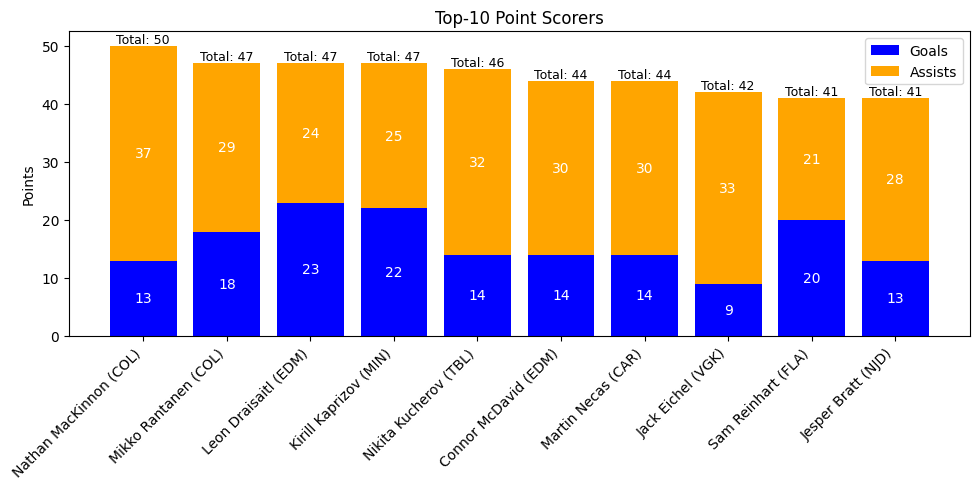

In [107]:
fig, ax = plt.subplots(figsize=(10,5))
bars_goals = ax.bar(players, goals, label='Goals', color='blue')
bars_assists = ax.bar(players, assists, label='Assists', bottom=goals, color='orange')

for bar_goal, bar_assist, goal, assist in zip(bars_goals, bars_assists, goals, assists):
    # Label for Goals
    ax.text(
        bar_goal.get_x() + bar_goal.get_width() / 2,  # Center x-coordinate
        bar_goal.get_height() / 2,                   # Midpoint of the bar
        str(goal),                                   # Goal value
        ha='center', va='center', color='white'
    )
    
    # Label for Assists
    ax.text(
        bar_assist.get_x() + bar_assist.get_width() / 2,  # Center x-coordinate
        bar_goal.get_height() + bar_assist.get_height() / 2,  # Midpoint of the top bar
        str(assist),                                     # Assist value
        ha='center', va='center', color='white'
    )

# Add total points label above the stacked bars
for i, total in enumerate(top10_point_scorers['points']):
    ax.text(
        i,                                               # x-coordinate (index of bar)
        goals.iloc[i] + assists.iloc[i],             # Slightly above the top bar
        f"Total: {total}",                               # Total points value
        ha='center', va='bottom', fontsize=9, color='black'
    )

ax.set_title('Top-10 Point Scorers')
ax.set_ylabel('Points')
ax.legend()

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Goalie Save Percentage against the League average 

In [108]:
df_goalies_performance.head()

,gameId,teamAbbrev,homeRoadFlag,gameDate,goals,assists,gamesStarted,decision,shotsAgainst,goalsAgainst,...,headshot,firstName,lastName,sweaterNumber,positionCode,shootsCatches,heightInCentimeters,weightInKilograms,birthDate,birthCountry
0,2024020439,WPG,H,2024-12-08,0,0,1,L,27,3,...,https://assets.nhle.com/mugs/nhl/20242025/WPG/...,Eric,Comrie,1,G,L,185,86,1995-07-06,CAN
1,2024020374,WPG,R,2024-11-29,0,0,1,L,30,4,...,https://assets.nhle.com/mugs/nhl/20242025/WPG/...,Eric,Comrie,1,G,L,185,86,1995-07-06,CAN
2,2024020329,WPG,R,2024-11-23,0,0,1,L,35,3,...,https://assets.nhle.com/mugs/nhl/20242025/WPG/...,Eric,Comrie,1,G,L,185,86,1995-07-06,CAN
3,2024020259,WPG,R,2024-11-14,0,0,1,L,28,3,...,https://assets.nhle.com/mugs/nhl/20242025/WPG/...,Eric,Comrie,1,G,L,185,86,1995-07-06,CAN
4,2024020171,WPG,R,2024-11-01,0,0,1,W,22,2,...,https://assets.nhle.com/mugs/nhl/20242025/WPG/...,Eric,Comrie,1,G,L,185,86,1995-07-06,CAN


In [109]:
top5_goalies_save_pct = df_goalies_performance.groupby(by=['id']).agg(
    shotsAgainst = ('shotsAgainst', 'sum'),
    goalsAgainst = ('goalsAgainst', 'sum'),
    gamesPlayed = ('gameId', 'count')
    ).reset_index()

In [110]:
top5_goalies_save_pct['savePct'] = 1 - top5_goalies_save_pct['goalsAgainst']/top5_goalies_save_pct['shotsAgainst']

In [111]:
min_games_played = (df_goalies_performance.groupby('teamAbbrev')['gameDate'].count().mean() * 0.35).round()

In [112]:
min_games_played

np.float64(11.0)

In [113]:
top5_goalies_save_pct.loc[top5_goalies_save_pct['gamesPlayed'] > min_games_played].sort_values(by=['savePct'], ascending=False).reset_index().drop(columns=['index']).head(5)

,id,shotsAgainst,goalsAgainst,gamesPlayed,savePct
0,8476932,480,35,17,0.927083
1,8476945,718,53,25,0.926184
2,8479406,630,49,22,0.922222
3,8480843,574,46,17,0.919861
4,8479361,316,26,12,0.917722


In [114]:
top5_goalies_save_pct = top5_goalies_save_pct.loc[top5_goalies_save_pct['gamesPlayed'] > min_games_played].sort_values(by=['savePct'], ascending=False).reset_index().drop(columns=['index']).head(5)

In [115]:
top5_goalies_save_pct_ids = top5_goalies_save_pct['id']

In [116]:
top5_goalies_save_pct_logs = df_goalies_performance[
    df_goalies_performance['id'].isin(top5_goalies_save_pct_ids)
    ][['id', 'gameDate','firstName', 'lastName', 'teamAbbrev', 'shotsAgainst', 'goalsAgainst']].sort_values(by=['id', 'gameDate'])

In [117]:
top5_goalies_save_pct_logs['id'].unique()

array([8476932, 8476945, 8479361, 8479406, 8480843])

In [118]:
top5_goalies_save_pct_logs['savePercent'] = 1 - top5_goalies_save_pct_logs['goalsAgainst'] / top5_goalies_save_pct_logs ['shotsAgainst']

In [119]:
top5_goalies_save_pct_logs.groupby('id')['savePercent'].rolling(window=5, min_periods=1).mean().reset_index(level=0, drop=True)

356    0.962963
355    0.938003
354    0.939061
353    0.935777
352    0.936857
         ...   
586    0.886633
585    0.892791
584    0.900463
583    0.913673
582    0.910876
Name: savePercent, Length: 93, dtype: float64

In [120]:
top5_goalies_save_pct_logs['rollingSavePercent'] = top5_goalies_save_pct_logs.groupby('id')['savePercent'].rolling(window=5, min_periods=1).mean().reset_index(level=0, drop=True)

In [121]:
top5_goalies_save_pct_logs['label'] = top5_goalies_save_pct_logs['firstName'] + ' ' + top5_goalies_save_pct_logs['lastName'] + ' (' + top5_goalies_save_pct_logs['teamAbbrev'] + ')'

In [122]:
top5_goalies_save_pct_logs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93 entries, 356 to 582
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  93 non-null     int64  
 1   gameDate            93 non-null     object 
 2   firstName           93 non-null     object 
 3   lastName            93 non-null     object 
 4   teamAbbrev          93 non-null     object 
 5   shotsAgainst        93 non-null     int64  
 6   goalsAgainst        93 non-null     int64  
 7   savePercent         93 non-null     float64
 8   rollingSavePercent  93 non-null     float64
 9   label               93 non-null     object 
dtypes: float64(2), int64(3), object(5)
memory usage: 8.0+ KB


In [123]:
top5_goalies_save_pct_logs = top5_goalies_save_pct_logs.astype({'gameDate': 'datetime64[s]'})

In [124]:
top5_goalies_save_pct_logs

,id,gameDate,firstName,lastName,teamAbbrev,shotsAgainst,goalsAgainst,savePercent,rollingSavePercent,label
356,8476932,2024-10-09,Anthony,Stolarz,TOR,27,1,0.962963,0.962963,Anthony Stolarz (TOR)
355,8476932,2024-10-12,Anthony,Stolarz,TOR,23,2,0.913043,0.938003,Anthony Stolarz (TOR)
354,8476932,2024-10-16,Anthony,Stolarz,TOR,34,2,0.941176,0.939061,Anthony Stolarz (TOR)
353,8476932,2024-10-19,Anthony,Stolarz,TOR,27,2,0.925926,0.935777,Anthony Stolarz (TOR)
352,8476932,2024-10-21,Anthony,Stolarz,TOR,34,2,0.941176,0.936857,Anthony Stolarz (TOR)
...,...,...,...,...,...,...,...,...,...,...
586,8480843,2024-11-18,Lukas,Dostal,ANA,36,2,0.944444,0.886633,Lukas Dostal (ANA)
585,8480843,2024-11-25,Lukas,Dostal,ANA,28,3,0.892857,0.892791,Lukas Dostal (ANA)
584,8480843,2024-12-01,Lukas,Dostal,ANA,31,3,0.903226,0.900463,Lukas Dostal (ANA)
583,8480843,2024-12-09,Lukas,Dostal,ANA,21,2,0.904762,0.913673,Lukas Dostal (ANA)


In [125]:
all_dates = pd.date_range(start=top5_goalies_save_pct_logs['gameDate'].min(), end=top5_goalies_save_pct_logs['gameDate'].max())

In [126]:
aligned_data = []

for id, group in top5_goalies_save_pct_logs.groupby('id'):
    group = group.set_index('gameDate').reindex(all_dates)
    group['id'] = id
    group['rollingSavePercent'] = group['rollingSavePercent'].interpolate(limit_area='inside')
    aligned_data.append(group)

top5_goalies_save_pct_logs_aligned = pd.concat(aligned_data)

top5_goalies_save_pct_logs_aligned = top5_goalies_save_pct_logs_aligned.reset_index().rename(columns={'index':'gameDate'})

top5_goalies_save_pct_logs_aligned['label'] = (
    top5_goalies_save_pct_logs_aligned['label'].dropna()
)

In [127]:
top5_goalies_save_pct_logs_aligned.loc[top5_goalies_save_pct_logs_aligned['id'] == 8480843].head()

,gameDate,id,firstName,lastName,teamAbbrev,shotsAgainst,goalsAgainst,savePercent,rollingSavePercent,label
268,2024-10-09,8480843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
269,2024-10-10,8480843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
270,2024-10-11,8480843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
271,2024-10-12,8480843,Lukas,Dostal,ANA,30.0,0.0,1.0,1.000000,Lukas Dostal (ANA)
272,2024-10-13,8480843,NaN,NaN,NaN,NaN,NaN,NaN,0.983333,NaN


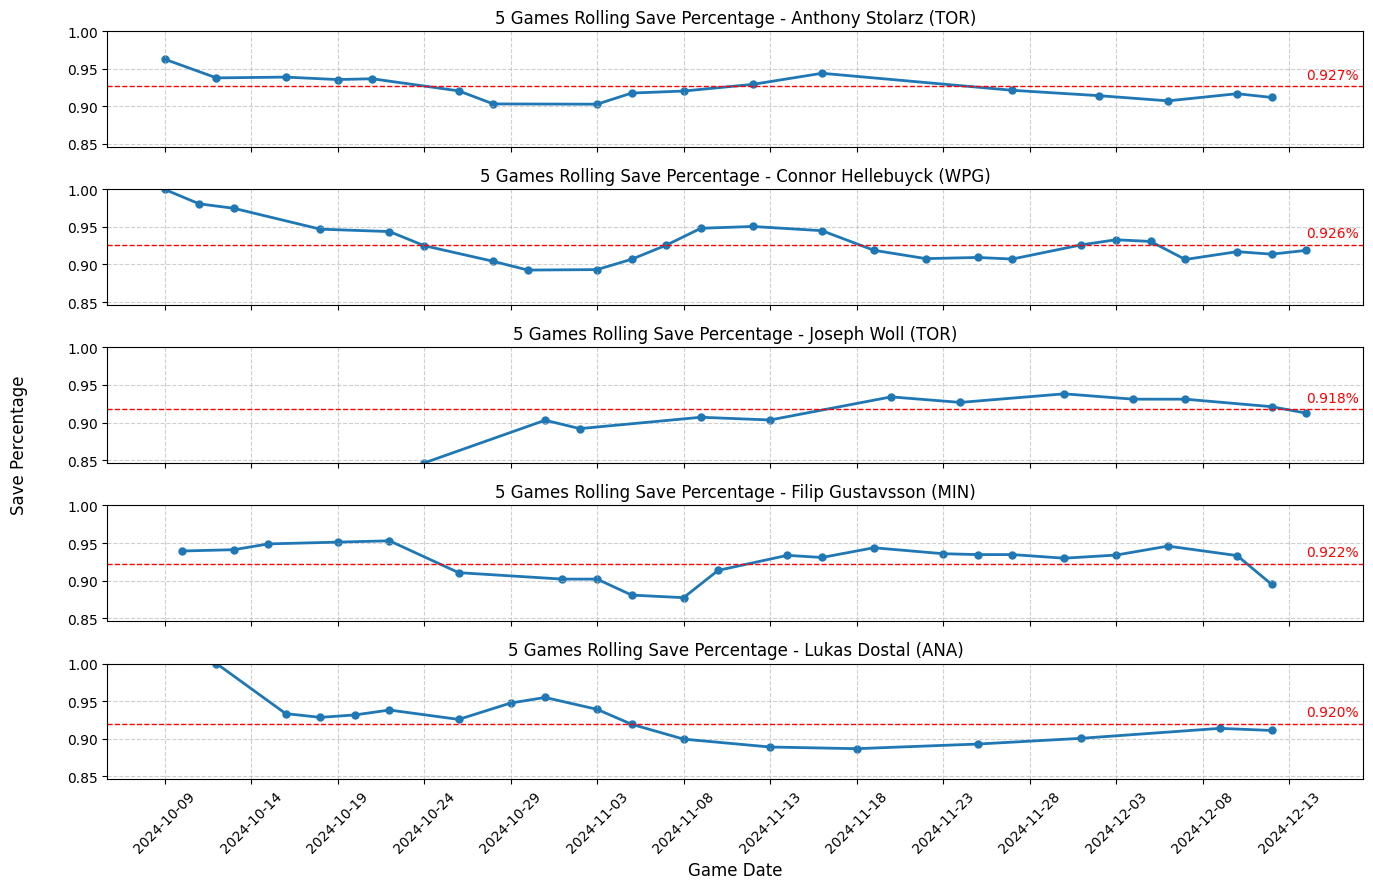

In [128]:
# Determine global Y-axis limits
y_min = top5_goalies_save_pct_logs_aligned['rollingSavePercent'].min()
y_max = top5_goalies_save_pct_logs_aligned['rollingSavePercent'].max()

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(14, 10), sharex=True)

# Iterate over subplots and goalie data
for ax, (id, group) in zip(axes, top5_goalies_save_pct_logs_aligned.groupby('id')):
    group_label = group['label'][group['label'].notnull()].unique()[0]
    avg_save_pct = 1- group['goalsAgainst'].sum() / group['shotsAgainst'].sum()

    # Line plot for rolling save percentage
    ax.plot(
        group['gameDate'], 
        group['rollingSavePercent'], 
        label=group_label,
        linewidth=2
    )
    
    # Scatter plot for save percentage points
    ax.scatter(
        group.loc[group['savePercent'].notna()]['gameDate'],
        group.loc[group['savePercent'].notna()]['rollingSavePercent'],
        marker='.',
        linewidths=3
    )

    ax.axhline(
        y=avg_save_pct,
        linewidth=1,
        linestyle='--',
        color='red',
        label=f'Avg. Save %'
    )

    ax.text(
        group['gameDate'].iloc[-1],  # Last game's date for placement
        avg_save_pct + 0.01,
        f"{avg_save_pct:.3f}%", 
        color='red', 
        fontsize=10, 
    )

    # Title, grid, and set uniform Y-axis limits
    ax.set_title(f"5 Games Rolling Save Percentage - {group_label}", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_ylim(y_min, y_max)  # Set consistent Y limits

# Global settings
axes[-1].set_xlabel('Game Date', fontsize=12)  # Add X-axis label only to the last subplot

# Global Y-axis label placed outside the chart area
fig.text(0.02, 0.5, 'Save Percentage', va='center', rotation='vertical', fontsize=12)

# Set uniform X ticks and format
xticks = top5_goalies_save_pct_logs_aligned['gameDate'].unique()  # Get unique X values
axes[-1].set_xticks(xticks[::5])  # Use every 5th tick for clarity
axes[-1].tick_params(axis='x', rotation=45)


# Adjust layout
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])  # Add padding for labels
plt.show()


## Load data in Google Cloud Storage

In [138]:
from google.cloud import storage
import datetime

In [130]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="creds/creds.json"

In [164]:
bucket_name = 'nhl-api-bucket'

In [131]:
client = storage.Client()

In [165]:
client.get_bucket(bucket_name)

<Bucket: nhl-api-bucket>

Uploading df_skaters_performance and df_goalies_performance data into a cloud bucket.

In [197]:
bucket = client.bucket('nhl-api-bucket')

In [198]:
ts = datetime.datetime.now().strftime("%d-%m-%Y-%H-%M-%S")

In [199]:
file_name = f"skaters_performance_{ts}"
blob = bucket.blob(f'{file_name}.csv')

In [200]:
blob.upload_from_string(df_skaters_performance.to_csv(index=False), 'text/csv')

Load data from GCS into a BQ table

In [201]:
from google.cloud import bigquery

In [202]:
bq_client = bigquery.Client()

In [203]:
dataset_id = "stg_nhl_data"

try: 
    bq_client.get_dataset(dataset_id)
except Exception:
    bq_client.create_dataset(dataset_id)

In [204]:
table_id = f"silent-effect-287314.{dataset_id}.{file_name}"

In [205]:
job_config = bigquery.LoadJobConfig(
    schema=[
            bigquery.SchemaField('gameId', "INT64"),
            bigquery.SchemaField('teamAbbrev', "STRING"),
            bigquery.SchemaField('homeRoadFlag', "STRING"),
            bigquery.SchemaField('gameDate', "DATE"),
            bigquery.SchemaField('goals', "INT64"),
            bigquery.SchemaField('assists', "INT64"),
            bigquery.SchemaField('points', "INT64"),
            bigquery.SchemaField('plusMinus', "INT64"),
            bigquery.SchemaField('powerPlayGoals', "INT64"),
            bigquery.SchemaField('powerPlayPoints', "INT64"),  
            bigquery.SchemaField('gameWinningGoals', "INT64"),
            bigquery.SchemaField('otGoals', "INT64"),
            bigquery.SchemaField('shots', "INT64"),
            bigquery.SchemaField('shifts', "INT64"),
            bigquery.SchemaField('shorthandedGoals', "INT64"),
            bigquery.SchemaField('shorthandedPoints', "INT64"),
            bigquery.SchemaField('opponentAbbrev', "STRING"),
            bigquery.SchemaField('pim', "INT64"),
            bigquery.SchemaField('toiInSeconds', "INT64" ),
            bigquery.SchemaField('playerId', "INT64" ),
            bigquery.SchemaField('seasonId', "INT64" ),
            bigquery.SchemaField('id', "INT64" ),
            bigquery.SchemaField('headshot', "STRING"),
            bigquery.SchemaField('firstName', "STRING"),
            bigquery.SchemaField('lastName', "STRING"),
            bigquery.SchemaField('sweaterNumber', "INT64" ),
            bigquery.SchemaField('positionCode', "STRING"),
            bigquery.SchemaField('shootsCatches', "STRING"),
            bigquery.SchemaField('heightInCentimeters', "INT64" ),
            bigquery.SchemaField('weightInKilograms', "INT64" ),
            bigquery.SchemaField('birthDate', "DATE"),
            bigquery.SchemaField('birthCountry', "STRING")
    ],
    skip_leading_rows=1
)

In [206]:
uri = f"gs://{bucket_name}/{file_name}.csv"

In [207]:
load_job = bq_client.load_table_from_uri(
    uri, table_id, job_config=job_config
)

In [208]:
load_job.result()  # Waits for the job to complete.

LoadJob<project=silent-effect-287314, location=US, id=94752543-6c92-4760-af07-68a6ef936a78>

In [210]:
destination_table = bq_client.get_table(table_id)
print("Loaded {} rows.".format(destination_table.num_rows))

Loaded 17289 rows.
